In [2]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score

In [3]:
import pandas as pd

train_update = pd.read_csv('./kaggle/input/spaceship-titanic/train_update.csv')
test_update = pd.read_csv('./kaggle/input/spaceship-titanic/test_update.csv')

# train_update = pd.read_csv('./kaggle/input/spaceship-titanic/train_TotalSpend_update.csv')
# test_update = pd.read_csv('./kaggle/input/spaceship-titanic/test_TotalSpend_update.csv')

In [4]:
train_update.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'TotalSpend', 'Name', 'Transported', 'testset'],
      dtype='object')

In [5]:
features = train_update.drop(['PassengerId','Transported','testset','Name'],axis=1)
labels = train_update['Transported']
X_train, X_test, y_train, y_test=train_test_split(features,labels,test_size=0.3,random_state=42)

In [55]:
# models = [XGBClassifier(),CatBoostClassifier()]
# scores = dict()

# for m in models:
#     m.fit(X_train, y_train)
#     y_pred = m.predict(X_test)

#     print(f'model: {str(m)}')
#     print(f'Accuracy_score: {accuracy_score(y_test,y_pred)}')
#     print(f'Precission_score: {precision_score(y_test,y_pred)}')
#     print(f'Recall_score: {recall_score(y_test,y_pred)}')
#     print(f'F1-score: {f1_score(y_test,y_pred)}')
#     print('-'*30, '\n')

In [6]:
import numpy as np
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    data, target = features,labels
    train_x, valid_x, train_y, valid_y = train_test_split(features,labels, test_size=0.3)


    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,3000),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,1),
        
    }


    xgb = XGBClassifier(**param)

    xgb.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = xgb.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### caution
- max depth를 12 이상으로 주지 않는 것이 좋은 이유
The default tree growing strategy in catboost is symmetric trees. If you set depth to 16, then every tree will have 2^16 leaves, which is probably not what you want. It is recommended to use depth up to 10 or 12.

    - [catboost pararmeter training](https://catboost.ai/en/docs/concepts/parameter-tuning)

###
1. 캐글 코드 참고
    - https://www.kaggle.com/code/georgyzubkov/spaceship-eda-catboost-with-optuna
2. 설명 블로그 참고
    - https://ssoonidev.tistory.com/107
3. catboost 주요 개념
    - https://dailyheumsi.tistory.com/136

In [7]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-10 22:06:56,660] A new study created in memory with name: no-name-0f2917fa-3229-4d4c-89ba-df21d55c853a
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:06:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:06:58,715] Trial 0 finished with value: 0.8086656441717791 and parameters: {'lambda': 2.1186417906127044, 'alpha': 2.541602009453039, 'colsample_bytree': 0.9444271832734408, 'subsample': 0.30243918815181553, 'learning_rate': 0.07327320403239396, 'n_estimators': 213, 'max_depth': 9, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.8086656441717791.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:06:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:06:59,907] Trial 1 finished with value: 0.8009969325153374 and parameters: {'lambda': 7.945131067096101, 'alpha': 7.030213539746182, 'colsample_bytree': 0.2130816128607939, 'subsample': 0.939444948062689, 'learning_rate': 0.07537223734430815, 'n_estimators': 1688, 'max_depth': 6, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.8086656441717791.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:06:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:01,020] Trial 2 finished with value: 0.80329754601227 and parameters: {'lambda': 7.709818274434296, 'alpha': 5.904867691723908, 'colsample_bytree': 0.35424078292274297, 'subsample': 0.7244576356548216, 'learning_rate': 0.038402014019609874, 'n_estimators': 1158, 'max_depth': 2, 'min_child_weight': 7, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.8086656441717791.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:02,048] Trial 3 finished with value: 0.7994631901840491 and parameters: {'lambda': 0.14305180979762966, 'alpha': 6.367381891209083, 'colsample_bytree': 0.7699849727178882, 'subsample': 0.6001148241411602, 'learning_rate': 0.027677464410743785, 'n_estimators': 596, 'max_depth': 7, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.8086656441717791.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:04,013] Trial 4 finished with value: 0.8009969325153374 and parameters: {'lambda': 0.45406442242604816, 'alpha': 8.186940450515287, 'colsample_bytree': 0.6097532706700892, 'subsample': 0.508961172590902, 'learning_rate': 0.014380520329882601, 'n_estimators': 1578, 'max_depth': 4, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.8086656441717791.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:04,836] Trial 5 finished with value: 0.799079754601227 and parameters: {'lambda': 9.696622135204503, 'alpha': 6.4805455085854895, 'colsample_bytree': 0.48586254997396694, 'subsample': 0.7179787572147418, 'learning_rate': 0.08244255272126054, 'n_estimators': 1470, 'max_depth': 3, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.8086656441717791.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:05,243] Trial 6 finished with value: 0.781441717791411 and parameters: {'lambda': 6.809679215429789, 'alpha': 8.002867019356634, 'colsample_bytree': 0.9304914687755663, 'subsample': 0.9832362647639492, 'learning_rate': 0.02433055599895496, 'n_estimators': 380, 'max_depth': 2, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.8086656441717791.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:06,308] Trial 7 finished with value: 0.799079754601227 and parameters: {'lambda': 0.8852106013118366, 'alpha': 7.8285315369791375, 'colsample_bytree': 0.20060331238945162, 'subsample': 0.6530820762053128, 'learning_rate': 0.08261505230229767, 'n_estimators': 952, 'max_depth': 7, 'min_child_weight': 6, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.8086656441717791.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:06,982] Trial 8 finished with value: 0.803680981595092 and parameters: {'lambda': 4.1017250861194, 'alpha': 8.106064842463354, 'colsample_bytree': 0.7117924049156045, 'subsample': 0.5179361978138883, 'learning_rate': 0.09892055519004238, 'n_estimators': 1102, 'max_depth': 6, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.8086656441717791.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:07,768] Trial 9 finished with value: 0.8101993865030674 and parameters: {'lambda': 0.9375659059949293, 'alpha': 4.629783901731107, 'colsample_bytree': 0.6091993290802243, 'subsample': 0.8893619562079569, 'learning_rate': 0.047825697777745146, 'n_estimators': 2646, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:08,552] Trial 10 finished with value: 0.8021472392638037 and parameters: {'lambda': 3.5511827125392137, 'alpha': 3.375012553629297, 'colsample_bytree': 0.4176003690418463, 'subsample': 0.8451767227240504, 'learning_rate': 0.05390435890922217, 'n_estimators': 2831, 'max_depth': 9, 'min_child_weight': 10, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:09,062] Trial 11 finished with value: 0.7979294478527608 and parameters: {'lambda': 2.5989969266075983, 'alpha': 0.11215443024426364, 'colsample_bytree': 0.9722193956019802, 'subsample': 0.2187278713369021, 'learning_rate': 0.05713859498000604, 'n_estimators': 2563, 'max_depth': 9, 'min_child_weight': 8, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:09,703] Trial 12 finished with value: 0.8044478527607362 and parameters: {'lambda': 2.1889404899520066, 'alpha': 3.7816326806859406, 'colsample_bytree': 0.8065354307524639, 'subsample': 0.27565671426331617, 'learning_rate': 0.06411347642780138, 'n_estimators': 2111, 'max_depth': 9, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:09,970] Trial 13 finished with value: 0.7975460122699386 and parameters: {'lambda': 5.235201991908879, 'alpha': 2.211445212903969, 'colsample_bytree': 0.6068918622845493, 'subsample': 0.3645335431671195, 'learning_rate': 0.04328388723148401, 'n_estimators': 137, 'max_depth': 10, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:10,518] Trial 14 finished with value: 0.7845092024539877 and parameters: {'lambda': 1.9219790958182181, 'alpha': 1.4545215303152461, 'colsample_bytree': 0.8810111316488309, 'subsample': 0.4103306562701101, 'learning_rate': 0.06892758176712327, 'n_estimators': 2200, 'max_depth': 5, 'min_child_weight': 9, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:11,069] Trial 15 finished with value: 0.8009969325153374 and parameters: {'lambda': 5.139353795664245, 'alpha': 4.3181846085352635, 'colsample_bytree': 0.674953640447028, 'subsample': 0.8386952066457998, 'learning_rate': 0.09865082081906358, 'n_estimators': 2154, 'max_depth': 8, 'min_child_weight': 6, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:14,807] Trial 16 finished with value: 0.7929447852760736 and parameters: {'lambda': 1.5121109241873816, 'alpha': 9.961987120891738, 'colsample_bytree': 0.3321814387288808, 'subsample': 0.39534841603875875, 'learning_rate': 0.007275800459418225, 'n_estimators': 2856, 'max_depth': 9, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:15,712] Trial 17 finished with value: 0.8013803680981595 and parameters: {'lambda': 3.109380737313284, 'alpha': 5.1770200030362785, 'colsample_bytree': 0.8417310042455203, 'subsample': 0.7851503684264842, 'learning_rate': 0.044162946015135617, 'n_estimators': 733, 'max_depth': 9, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:17,162] Trial 18 finished with value: 0.7948619631901841 and parameters: {'lambda': 4.278404875523402, 'alpha': 2.5636282652846574, 'colsample_bytree': 0.5542630604516118, 'subsample': 0.5117903400106003, 'learning_rate': 0.03067199612435391, 'n_estimators': 1838, 'max_depth': 4, 'min_child_weight': 7, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:17,667] Trial 19 finished with value: 0.80329754601227 and parameters: {'lambda': 1.0743627661649995, 'alpha': 1.0524128587241606, 'colsample_bytree': 0.7096269058081299, 'subsample': 0.9149975313064013, 'learning_rate': 0.08588743981918401, 'n_estimators': 2476, 'max_depth': 5, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:18,507] Trial 20 finished with value: 0.7983128834355828 and parameters: {'lambda': 6.113094244641289, 'alpha': 4.545567758955737, 'colsample_bytree': 0.997834211317591, 'subsample': 0.3153016453128554, 'learning_rate': 0.06282632494420412, 'n_estimators': 1302, 'max_depth': 10, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:19,075] Trial 21 finished with value: 0.7971625766871165 and parameters: {'lambda': 2.3265285184466635, 'alpha': 3.7781641356421938, 'colsample_bytree': 0.8156733875567487, 'subsample': 0.2439366965786792, 'learning_rate': 0.0637702666115657, 'n_estimators': 2014, 'max_depth': 9, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:19,502] Trial 22 finished with value: 0.7925613496932515 and parameters: {'lambda': 2.1118548253575833, 'alpha': 3.0224309854898292, 'colsample_bytree': 0.7789811653364911, 'subsample': 0.31701946120882835, 'learning_rate': 0.07166072563915564, 'n_estimators': 2412, 'max_depth': 9, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:20,323] Trial 23 finished with value: 0.7960122699386503 and parameters: {'lambda': 0.03128614849973976, 'alpha': 4.888789840276722, 'colsample_bytree': 0.8900042121138967, 'subsample': 0.4577916256858969, 'learning_rate': 0.05301086334608094, 'n_estimators': 2961, 'max_depth': 9, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:20,954] Trial 24 finished with value: 0.7963957055214724 and parameters: {'lambda': 2.82922446178882, 'alpha': 1.8569440593828075, 'colsample_bytree': 0.6651715247579739, 'subsample': 0.28509186779205553, 'learning_rate': 0.06211126021686781, 'n_estimators': 1928, 'max_depth': 3, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 9 with value: 0.8101993865030674.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:21,817] Trial 25 finished with value: 0.8121165644171779 and parameters: {'lambda': 1.3714918130838825, 'alpha': 3.5671107752942075, 'colsample_bytree': 0.7660750854336492, 'subsample': 0.5923142816180467, 'learning_rate': 0.04597851373997013, 'n_estimators': 2706, 'max_depth': 8, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:22,671] Trial 26 finished with value: 0.790260736196319 and parameters: {'lambda': 1.2524583517498893, 'alpha': 0.6857002533290881, 'colsample_bytree': 0.47202816429525796, 'subsample': 0.5752484670549757, 'learning_rate': 0.03493092426715255, 'n_estimators': 2654, 'max_depth': 8, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:23,667] Trial 27 finished with value: 0.8059815950920245 and parameters: {'lambda': 3.428296618493632, 'alpha': 5.518003611575262, 'colsample_bytree': 0.913821093790063, 'subsample': 0.6326433975371911, 'learning_rate': 0.045117039673094286, 'n_estimators': 2301, 'max_depth': 8, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:24,679] Trial 28 finished with value: 0.7967791411042945 and parameters: {'lambda': 1.503887816262708, 'alpha': 3.050826378154202, 'colsample_bytree': 0.7444103081467267, 'subsample': 0.740451933837049, 'learning_rate': 0.020993698989200334, 'n_estimators': 2764, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:26,098] Trial 29 finished with value: 0.7979294478527608 and parameters: {'lambda': 0.6168337780777009, 'alpha': 4.161024877659415, 'colsample_bytree': 0.14439534250358427, 'subsample': 0.8916170304745868, 'learning_rate': 0.07652294305578485, 'n_estimators': 1731, 'max_depth': 6, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:26,781] Trial 30 finished with value: 0.8113496932515337 and parameters: {'lambda': 4.2691392879085, 'alpha': 2.480615815170543, 'colsample_bytree': 0.6200752437464883, 'subsample': 0.9978740454381386, 'learning_rate': 0.0496254571316071, 'n_estimators': 3000, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:27,613] Trial 31 finished with value: 0.8055981595092024 and parameters: {'lambda': 4.351339738293467, 'alpha': 2.8085633718780527, 'colsample_bytree': 0.5769742686953077, 'subsample': 0.9955062293993429, 'learning_rate': 0.05058276055435532, 'n_estimators': 2653, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:28,547] Trial 32 finished with value: 0.8113496932515337 and parameters: {'lambda': 5.894114118861163, 'alpha': 1.9798888365362066, 'colsample_bytree': 0.6547429445798886, 'subsample': 0.8710783771793902, 'learning_rate': 0.035226383143381376, 'n_estimators': 2971, 'max_depth': 8, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:29,491] Trial 33 finished with value: 0.790260736196319 and parameters: {'lambda': 6.536836557918892, 'alpha': 1.7524428027758598, 'colsample_bytree': 0.6391813837444135, 'subsample': 0.8720432366150062, 'learning_rate': 0.03383136939935916, 'n_estimators': 2999, 'max_depth': 8, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:30,461] Trial 34 finished with value: 0.8071319018404908 and parameters: {'lambda': 7.586569835486502, 'alpha': 2.206567727232553, 'colsample_bytree': 0.5208375409375979, 'subsample': 0.9387841102255065, 'learning_rate': 0.040246549899163916, 'n_estimators': 2730, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:31,327] Trial 35 finished with value: 0.7998466257668712 and parameters: {'lambda': 5.966532236389557, 'alpha': 3.690241436441657, 'colsample_bytree': 0.7140599090853044, 'subsample': 0.8186388171455006, 'learning_rate': 0.047306224665158374, 'n_estimators': 2386, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:32,544] Trial 36 finished with value: 0.808282208588957 and parameters: {'lambda': 7.437521941657431, 'alpha': 1.1215828669535712, 'colsample_bytree': 0.4162601574300069, 'subsample': 0.9557865404673528, 'learning_rate': 0.037132424173988036, 'n_estimators': 2989, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:34,776] Trial 37 finished with value: 0.7837423312883436 and parameters: {'lambda': 9.068218091783963, 'alpha': 6.291001485441845, 'colsample_bytree': 0.6174748653359906, 'subsample': 0.6962556466903788, 'learning_rate': 0.0218991465895184, 'n_estimators': 2544, 'max_depth': 2, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:35,404] Trial 38 finished with value: 0.808282208588957 and parameters: {'lambda': 8.805442677482143, 'alpha': 0.2796034523662261, 'colsample_bytree': 0.5499241689071999, 'subsample': 0.7648107905329902, 'learning_rate': 0.05782923342399085, 'n_estimators': 2793, 'max_depth': 7, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:38,464] Trial 39 finished with value: 0.7864263803680982 and parameters: {'lambda': 5.755058188357618, 'alpha': 5.663246924785096, 'colsample_bytree': 0.49822218398326423, 'subsample': 0.571702036199952, 'learning_rate': 0.013529185682252039, 'n_estimators': 2569, 'max_depth': 4, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 25 with value: 0.8121165644171779.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:41,358] Trial 40 finished with value: 0.8182515337423313 and parameters: {'lambda': 4.765956631322167, 'alpha': 7.278969272081835, 'colsample_bytree': 0.6641875700915917, 'subsample': 0.688162062678529, 'learning_rate': 0.02715737843456302, 'n_estimators': 2865, 'max_depth': 8, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:43,134] Trial 41 finished with value: 0.8025306748466258 and parameters: {'lambda': 3.8931640085643577, 'alpha': 7.06113510401486, 'colsample_bytree': 0.6734551570943782, 'subsample': 0.8018905658738688, 'learning_rate': 0.028272242847508795, 'n_estimators': 2850, 'max_depth': 8, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:45,172] Trial 42 finished with value: 0.7971625766871165 and parameters: {'lambda': 4.959679395699285, 'alpha': 9.447385877122437, 'colsample_bytree': 0.7524261769020115, 'subsample': 0.9600895839934622, 'learning_rate': 0.03979437398506529, 'n_estimators': 2876, 'max_depth': 8, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:47,562] Trial 43 finished with value: 0.803680981595092 and parameters: {'lambda': 4.574127289615108, 'alpha': 7.542691028830653, 'colsample_bytree': 0.5905364315255655, 'subsample': 0.6644988667012262, 'learning_rate': 0.016853801619916495, 'n_estimators': 2650, 'max_depth': 3, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:49,437] Trial 44 finished with value: 0.8002300613496932 and parameters: {'lambda': 6.782804534969461, 'alpha': 3.3180249102366437, 'colsample_bytree': 0.6341522010589788, 'subsample': 0.9024544837779684, 'learning_rate': 0.04899913511461451, 'n_estimators': 2278, 'max_depth': 2, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:50,493] Trial 45 finished with value: 0.807898773006135 and parameters: {'lambda': 5.517961788582006, 'alpha': 4.856209669295438, 'colsample_bytree': 0.44723834452712935, 'subsample': 0.695054989224894, 'learning_rate': 0.03162983519237002, 'n_estimators': 2705, 'max_depth': 8, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:52,923] Trial 46 finished with value: 0.8006134969325154 and parameters: {'lambda': 4.787386701422945, 'alpha': 8.57425780364285, 'colsample_bytree': 0.7149788789842431, 'subsample': 0.860057271440105, 'learning_rate': 0.025241683741559523, 'n_estimators': 2903, 'max_depth': 6, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:53,417] Trial 47 finished with value: 0.8029141104294478 and parameters: {'lambda': 3.6339024573929968, 'alpha': 2.2349061392345586, 'colsample_bytree': 0.8392914012562473, 'subsample': 0.6132209017074305, 'learning_rate': 0.05694842906160463, 'n_estimators': 2486, 'max_depth': 7, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:54,074] Trial 48 finished with value: 0.7998466257668712 and parameters: {'lambda': 0.48263774723067243, 'alpha': 4.086726881876602, 'colsample_bytree': 0.5442148534510145, 'subsample': 0.5597382486383157, 'learning_rate': 0.04232343802974653, 'n_estimators': 325, 'max_depth': 10, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:56,394] Trial 49 finished with value: 0.7937116564417178 and parameters: {'lambda': 6.3243368749972175, 'alpha': 6.902677659632946, 'colsample_bytree': 0.671057150408192, 'subsample': 0.9311079213299731, 'learning_rate': 0.007412702749349048, 'n_estimators': 1510, 'max_depth': 5, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:58,007] Trial 50 finished with value: 0.7986963190184049 and parameters: {'lambda': 7.169486346556585, 'alpha': 6.15261354719085, 'colsample_bytree': 0.7848926801489005, 'subsample': 0.9779918649667557, 'learning_rate': 0.03728558300649118, 'n_estimators': 2791, 'max_depth': 8, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:58,415] Trial 51 finished with value: 0.7914110429447853 and parameters: {'lambda': 2.704746434832925, 'alpha': 2.460915016823389, 'colsample_bytree': 0.5777949911935569, 'subsample': 0.7467668415150308, 'learning_rate': 0.0940672647739679, 'n_estimators': 828, 'max_depth': 9, 'min_child_weight': 6, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:59,178] Trial 52 finished with value: 0.8055981595092024 and parameters: {'lambda': 1.628364070607321, 'alpha': 3.5176424873046863, 'colsample_bytree': 0.6482436444346157, 'subsample': 0.846931049647676, 'learning_rate': 0.052939522452200426, 'n_estimators': 1163, 'max_depth': 9, 'min_child_weight': 6, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:07:59,766] Trial 53 finished with value: 0.7944785276073619 and parameters: {'lambda': 0.7046883437259466, 'alpha': 1.7721813486253961, 'colsample_bytree': 0.9678347952599593, 'subsample': 0.46116930296669245, 'learning_rate': 0.04695976329928208, 'n_estimators': 367, 'max_depth': 8, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:07:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:00,437] Trial 54 finished with value: 0.7891104294478528 and parameters: {'lambda': 5.494307845186977, 'alpha': 3.1425313957877883, 'colsample_bytree': 0.8634757747586899, 'subsample': 0.47658016391263924, 'learning_rate': 0.0584609114847537, 'n_estimators': 481, 'max_depth': 4, 'min_child_weight': 7, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:00,873] Trial 55 finished with value: 0.8013803680981595 and parameters: {'lambda': 1.731257922994138, 'alpha': 1.3485534926588825, 'colsample_bytree': 0.7033855843182801, 'subsample': 0.8840797041878967, 'learning_rate': 0.06937951574725376, 'n_estimators': 1306, 'max_depth': 9, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:01,776] Trial 56 finished with value: 0.7960122699386503 and parameters: {'lambda': 3.1366879688196274, 'alpha': 4.528738322418958, 'colsample_bytree': 0.7479442461421597, 'subsample': 0.4141285675785903, 'learning_rate': 0.04258068860249652, 'n_estimators': 2591, 'max_depth': 3, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:02,014] Trial 57 finished with value: 0.7921779141104295 and parameters: {'lambda': 1.248097547324829, 'alpha': 5.247525821801406, 'colsample_bytree': 0.9410326578582426, 'subsample': 0.822952066383179, 'learning_rate': 0.0284880083174348, 'n_estimators': 125, 'max_depth': 5, 'min_child_weight': 10, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:02,908] Trial 58 finished with value: 0.7967791411042945 and parameters: {'lambda': 2.265657982847193, 'alpha': 2.6953274370227414, 'colsample_bytree': 0.6114987734347155, 'subsample': 0.20443359391095534, 'learning_rate': 0.03469881797819362, 'n_estimators': 2921, 'max_depth': 10, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:07,335] Trial 59 finished with value: 0.7726226993865031 and parameters: {'lambda': 0.13287746173441917, 'alpha': 2.0615198853198926, 'colsample_bytree': 0.33379167714686336, 'subsample': 0.5415502915000316, 'learning_rate': 0.0004545107035870202, 'n_estimators': 2361, 'max_depth': 9, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:08,276] Trial 60 finished with value: 0.7956288343558282 and parameters: {'lambda': 4.117883072351219, 'alpha': 4.0580653254241055, 'colsample_bytree': 0.252948749198953, 'subsample': 0.7807453077215065, 'learning_rate': 0.08880697401228153, 'n_estimators': 2068, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:09,139] Trial 61 finished with value: 0.8006134969325154 and parameters: {'lambda': 8.423107901723466, 'alpha': 1.09926997085025, 'colsample_bytree': 0.5104059116579747, 'subsample': 0.973669712418852, 'learning_rate': 0.03628593903502897, 'n_estimators': 2965, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:09,629] Trial 62 finished with value: 0.7983128834355828 and parameters: {'lambda': 9.726686593595199, 'alpha': 0.19919209134890203, 'colsample_bytree': 0.6937106073435634, 'subsample': 0.779263029300855, 'learning_rate': 0.07506617860322214, 'n_estimators': 2828, 'max_depth': 7, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:10,359] Trial 63 finished with value: 0.790260736196319 and parameters: {'lambda': 8.006763970187894, 'alpha': 0.5352682108522351, 'colsample_bytree': 0.5490289629656799, 'subsample': 0.7513093891918116, 'learning_rate': 0.05948694156333102, 'n_estimators': 2750, 'max_depth': 7, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:10,797] Trial 64 finished with value: 0.7914110429447853 and parameters: {'lambda': 8.814328509356777, 'alpha': 1.5153215104979614, 'colsample_bytree': 0.5969903921109112, 'subsample': 0.6715032238328988, 'learning_rate': 0.06633575992026523, 'n_estimators': 2831, 'max_depth': 7, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:11,363] Trial 65 finished with value: 0.7944785276073619 and parameters: {'lambda': 0.9352416380885558, 'alpha': 1.1683684794120106, 'colsample_bytree': 0.4483815570022437, 'subsample': 0.9514219893533642, 'learning_rate': 0.050421045310223206, 'n_estimators': 2992, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:12,438] Trial 66 finished with value: 0.7948619631901841 and parameters: {'lambda': 7.59792064186692, 'alpha': 0.861132406315646, 'colsample_bytree': 0.4136004278002825, 'subsample': 0.9188331002006298, 'learning_rate': 0.04016710171017836, 'n_estimators': 2464, 'max_depth': 8, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:13,219] Trial 67 finished with value: 0.8159509202453987 and parameters: {'lambda': 1.9985140971212108, 'alpha': 2.6651194837117727, 'colsample_bytree': 0.5382072713937617, 'subsample': 0.7200135347262647, 'learning_rate': 0.055467002522952905, 'n_estimators': 2675, 'max_depth': 7, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:13,751] Trial 68 finished with value: 0.7967791411042945 and parameters: {'lambda': 2.4785845118543874, 'alpha': 2.5105422502156025, 'colsample_bytree': 0.8001702685418879, 'subsample': 0.6280296217452738, 'learning_rate': 0.05463157332585784, 'n_estimators': 2244, 'max_depth': 6, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:14,171] Trial 69 finished with value: 0.8067484662576687 and parameters: {'lambda': 1.8661965322173053, 'alpha': 2.861741919382869, 'colsample_bytree': 0.6434451494976507, 'subsample': 0.7218798700286881, 'learning_rate': 0.08018318452573768, 'n_estimators': 1663, 'max_depth': 9, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:14,992] Trial 70 finished with value: 0.7960122699386503 and parameters: {'lambda': 3.0158239308176196, 'alpha': 3.37616126824299, 'colsample_bytree': 0.7312366374783328, 'subsample': 0.8197054620960954, 'learning_rate': 0.03262658506258112, 'n_estimators': 2702, 'max_depth': 7, 'min_child_weight': 6, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:15,815] Trial 71 finished with value: 0.7983128834355828 and parameters: {'lambda': 7.02958951272865, 'alpha': 1.5677700681217352, 'colsample_bytree': 0.3795722199827387, 'subsample': 0.9862218275578584, 'learning_rate': 0.045374386998710284, 'n_estimators': 2612, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:16,667] Trial 72 finished with value: 0.8025306748466258 and parameters: {'lambda': 1.2606052230822926, 'alpha': 1.9634824588163609, 'colsample_bytree': 0.46849813180734245, 'subsample': 0.3662475928997689, 'learning_rate': 0.051360972577934226, 'n_estimators': 2996, 'max_depth': 2, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:17,390] Trial 73 finished with value: 0.7956288343558282 and parameters: {'lambda': 3.517623787522404, 'alpha': 3.088089719202898, 'colsample_bytree': 0.5286071043711147, 'subsample': 0.6920155088386114, 'learning_rate': 0.06593779837275228, 'n_estimators': 2761, 'max_depth': 7, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:18,041] Trial 74 finished with value: 0.7929447852760736 and parameters: {'lambda': 2.1589571427627985, 'alpha': 3.8099286673449657, 'colsample_bytree': 0.5689125075848763, 'subsample': 0.7592235739492275, 'learning_rate': 0.06069410850968008, 'n_estimators': 2881, 'max_depth': 7, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:18,651] Trial 75 finished with value: 0.7940950920245399 and parameters: {'lambda': 0.3107971785974719, 'alpha': 2.336571293089322, 'colsample_bytree': 0.6171797680651322, 'subsample': 0.7153459532509863, 'learning_rate': 0.04871055205829375, 'n_estimators': 2523, 'max_depth': 7, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:19,541] Trial 76 finished with value: 0.808282208588957 and parameters: {'lambda': 4.618000257771183, 'alpha': 8.708917350810426, 'colsample_bytree': 0.5586349339980617, 'subsample': 0.7944840193155442, 'learning_rate': 0.055537457043835295, 'n_estimators': 2693, 'max_depth': 4, 'min_child_weight': 8, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:20,660] Trial 77 finished with value: 0.7983128834355828 and parameters: {'lambda': 5.207966340006452, 'alpha': 2.564186921557713, 'colsample_bytree': 0.38283669509175366, 'subsample': 0.910455864810755, 'learning_rate': 0.02640895991788874, 'n_estimators': 2914, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:22,267] Trial 78 finished with value: 0.7975460122699386 and parameters: {'lambda': 4.721037181110707, 'alpha': 8.843224489939802, 'colsample_bytree': 0.6872037378697565, 'subsample': 0.7995391960042295, 'learning_rate': 0.0552031159262813, 'n_estimators': 2674, 'max_depth': 4, 'min_child_weight': 8, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:22,850] Trial 79 finished with value: 0.7898773006134969 and parameters: {'lambda': 1.4532755344113462, 'alpha': 4.580954021388001, 'colsample_bytree': 0.6534581218430612, 'subsample': 0.8705520376466198, 'learning_rate': 0.07254954797842517, 'n_estimators': 1899, 'max_depth': 9, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:24,306] Trial 80 finished with value: 0.7883435582822086 and parameters: {'lambda': 9.325214575374961, 'alpha': 3.769799554962106, 'colsample_bytree': 0.5359830117874957, 'subsample': 0.8411927530555182, 'learning_rate': 0.02246593714464264, 'n_estimators': 2806, 'max_depth': 3, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:26,024] Trial 81 finished with value: 0.7979294478527608 and parameters: {'lambda': 4.447170250499992, 'alpha': 8.814418037749613, 'colsample_bytree': 0.48311350707123174, 'subsample': 0.9368556818878266, 'learning_rate': 0.03879734030142564, 'n_estimators': 2891, 'max_depth': 4, 'min_child_weight': 9, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:28,612] Trial 82 finished with value: 0.7971625766871165 and parameters: {'lambda': 3.8581545378654525, 'alpha': 7.634734233423206, 'colsample_bytree': 0.2903625424605103, 'subsample': 0.8929213344646436, 'learning_rate': 0.02985366177736282, 'n_estimators': 2608, 'max_depth': 4, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:29,191] Trial 83 finished with value: 0.7940950920245399 and parameters: {'lambda': 8.599065441949563, 'alpha': 0.007320730552397237, 'colsample_bytree': 0.5901274695826075, 'subsample': 0.6523242723831039, 'learning_rate': 0.043457332474087756, 'n_estimators': 242, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:30,074] Trial 84 finished with value: 0.8063650306748467 and parameters: {'lambda': 7.829768302230852, 'alpha': 0.5624601018937927, 'colsample_bytree': 0.6290497122641043, 'subsample': 0.9524922596676016, 'learning_rate': 0.04610918033190288, 'n_estimators': 2779, 'max_depth': 8, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:31,672] Trial 85 finished with value: 0.7971625766871165 and parameters: {'lambda': 5.665512050819933, 'alpha': 9.888448916421266, 'colsample_bytree': 0.5667490630800447, 'subsample': 0.76816111848412, 'learning_rate': 0.056210764654626814, 'n_estimators': 2430, 'max_depth': 4, 'min_child_weight': 8, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:32,201] Trial 86 finished with value: 0.7956288343558282 and parameters: {'lambda': 9.99355745522223, 'alpha': 1.6477562852673984, 'colsample_bytree': 0.7618849679957169, 'subsample': 0.6036892124477514, 'learning_rate': 0.05230721206441811, 'n_estimators': 600, 'max_depth': 8, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:33,366] Trial 87 finished with value: 0.8094325153374233 and parameters: {'lambda': 4.936634660304131, 'alpha': 2.810614104687367, 'colsample_bytree': 0.6810107795654958, 'subsample': 0.26139976808345106, 'learning_rate': 0.03627189172424275, 'n_estimators': 2347, 'max_depth': 9, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:35,308] Trial 88 finished with value: 0.8017638036809815 and parameters: {'lambda': 6.165402366994902, 'alpha': 8.361514097889978, 'colsample_bytree': 0.673845495111815, 'subsample': 0.2821482281273932, 'learning_rate': 0.048191072389986885, 'n_estimators': 2344, 'max_depth': 9, 'min_child_weight': 9, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:36,156] Trial 89 finished with value: 0.7956288343558282 and parameters: {'lambda': 4.901205025479344, 'alpha': 2.1049649007244, 'colsample_bytree': 0.903659636944548, 'subsample': 0.32391897522559454, 'learning_rate': 0.042033393435147524, 'n_estimators': 1405, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:37,020] Trial 90 finished with value: 0.8109662576687117 and parameters: {'lambda': 2.014907871247183, 'alpha': 2.8832621396484353, 'colsample_bytree': 0.7276596873252243, 'subsample': 0.30057566544217745, 'learning_rate': 0.060952809328626414, 'n_estimators': 1034, 'max_depth': 9, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:37,606] Trial 91 finished with value: 0.7963957055214724 and parameters: {'lambda': 1.9568428019670179, 'alpha': 2.8694399847063274, 'colsample_bytree': 0.7322215803267541, 'subsample': 0.23532823803938996, 'learning_rate': 0.03652012825790438, 'n_estimators': 1008, 'max_depth': 9, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:38,177] Trial 92 finished with value: 0.7983128834355828 and parameters: {'lambda': 5.423675528614174, 'alpha': 3.258958110262281, 'colsample_bytree': 0.6640818364652833, 'subsample': 0.30181769788698987, 'learning_rate': 0.06623370538282423, 'n_estimators': 712, 'max_depth': 9, 'min_child_weight': 7, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:38,716] Trial 93 finished with value: 0.7971625766871165 and parameters: {'lambda': 0.845981600890247, 'alpha': 3.6047627481743714, 'colsample_bytree': 0.8239866221436206, 'subsample': 0.26563181734512537, 'learning_rate': 0.0630284181615236, 'n_estimators': 2508, 'max_depth': 9, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:39,300] Trial 94 finished with value: 0.7994631901840491 and parameters: {'lambda': 2.465486542090686, 'alpha': 2.679611828246582, 'colsample_bytree': 0.7172311146528708, 'subsample': 0.3366439377903985, 'learning_rate': 0.05829442800258877, 'n_estimators': 2927, 'max_depth': 9, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:40,368] Trial 95 finished with value: 0.80329754601227 and parameters: {'lambda': 4.561422976607201, 'alpha': 7.135435817243717, 'colsample_bytree': 0.7880427176532152, 'subsample': 0.35194899479696307, 'learning_rate': 0.0536913085509033, 'n_estimators': 2679, 'max_depth': 5, 'min_child_weight': 4, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:41,496] Trial 96 finished with value: 0.7894938650306749 and parameters: {'lambda': 1.1211436820757994, 'alpha': 2.941266319141129, 'colsample_bytree': 0.6195951551501245, 'subsample': 0.2655130621011269, 'learning_rate': 0.01907618367830216, 'n_estimators': 1142, 'max_depth': 10, 'min_child_weight': 3, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:42,513] Trial 97 finished with value: 0.8040644171779141 and parameters: {'lambda': 1.4678849179952096, 'alpha': 2.3077788154603103, 'colsample_bytree': 0.6546372997628824, 'subsample': 0.2946138082818365, 'learning_rate': 0.033569927221792084, 'n_estimators': 2857, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:42] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:43,480] Trial 98 finished with value: 0.7979294478527608 and parameters: {'lambda': 5.103830124179503, 'alpha': 5.9903440807082955, 'colsample_bytree': 0.6902809716173609, 'subsample': 0.23884635285104003, 'learning_rate': 0.06161239510094243, 'n_estimators': 2142, 'max_depth': 6, 'min_child_weight': 5, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:08:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "used_ram_limit" } are not used.



[I 2022-12-10 22:08:46,153] Trial 99 finished with value: 0.8013803680981595 and parameters: {'lambda': 5.861152719336658, 'alpha': 1.8508943831175526, 'colsample_bytree': 0.9997825537279346, 'subsample': 0.9959556771594089, 'learning_rate': 0.03890547014163803, 'n_estimators': 2955, 'max_depth': 2, 'min_child_weight': 2, 'num_parallel_tree': 1}. Best is trial 40 with value: 0.8182515337423313.


Number of finished trials: 100
Best trial:
  Value: 0.8182515337423313
  Params: 
    lambda: 4.765956631322167
    alpha: 7.278969272081835
    colsample_bytree: 0.6641875700915917
    subsample: 0.688162062678529
    learning_rate: 0.02715737843456302
    n_estimators: 2865
    max_depth: 8
    min_child_weight: 4
    num_parallel_tree: 1


In [8]:
from optuna import visualization
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
hist = study.trials_dataframe()
hist.head()

Best trial: score 0.8182515337423313,
params {'lambda': 4.765956631322167, 'alpha': 7.278969272081835, 'colsample_bytree': 0.6641875700915917, 'subsample': 0.688162062678529, 'learning_rate': 0.02715737843456302, 'n_estimators': 2865, 'max_depth': 8, 'min_child_weight': 4, 'num_parallel_tree': 1}


,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_num_parallel_tree,params_subsample,state
0,0,0.808666,2022-12-10 22:06:56.661177,2022-12-10 22:06:58.715114,0 days 00:00:02.053937,2.541602,0.944427,2.118642,0.073273,9,5,213,1,0.302439,COMPLETE
1,1,0.800997,2022-12-10 22:06:58.716116,2022-12-10 22:06:59.907588,0 days 00:00:01.191472,7.030214,0.213082,7.945131,0.075372,6,1,1688,1,0.939445,COMPLETE
2,2,0.803298,2022-12-10 22:06:59.908591,2022-12-10 22:07:01.020752,0 days 00:00:01.112161,5.904868,0.354241,7.709818,0.038402,2,7,1158,1,0.724458,COMPLETE
3,3,0.799463,2022-12-10 22:07:01.021835,2022-12-10 22:07:02.048519,0 days 00:00:01.026684,6.367382,0.769985,0.143052,0.027677,7,2,596,1,0.600115,COMPLETE
4,4,0.800997,2022-12-10 22:07:02.049521,2022-12-10 22:07:04.012843,0 days 00:00:01.963322,8.186940,0.609753,0.454064,0.014381,4,5,1578,1,0.508961,COMPLETE


In [20]:
# optuna.visualization.plot_slice(study)

In [23]:
# optuna.visualization.plot_optimization_history(study)

In [9]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [num_parallel_tree (IntDistribution):
                                0.0<extra></extra>, subsample (FloatDistribution):
                                0.024040121882868516<extra></extra>,
                                min_child_weight (IntDistribution):
                                0.04007745931251076<extra></extra>,
                                colsample_bytree (FloatDistribution):
                                0.05837373479523927<extra></extra>, n_estimators
                                (IntDistribution):
                                0.06268151408925464<extra></extra>, max_depth
                                (CategoricalDistribution):
                                0.07201330417631227<extra></extra>, lambda
                                (FloatDistribution):
                                0.07891448848639333<extra></extra>, alpha
                                (FloatDistribution):
                                0.11848841755315273<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.5454109597042686<extra></extra>],
              'marker': {'color': 'rgb(66,146,198)'},
              'orientation': 'h',
              'text': [<0.01, 0.02, 0.04, 0.06, 0.06, 0.07, 0.08, 0.12, 0.55],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0, 0.024040121882868516, 0.04007745931251076,
                    0.05837373479523927, 0.06268151408925464, 0.07201330417631227,
                    0.07891448848639333, 0.11848841755315273, 0.5454109597042686],
              'y': [num_parallel_tree, subsample, min_child_weight,
                    colsample_bytree, n_estimators, max_depth, lambda, alpha,
                    learning_rate]}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Importance for Objective Value'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [60]:
# {'lambda': 4.765956631322167, 'alpha': 7.278969272081835, 'colsample_bytree': 0.6641875700915917,
#  'subsample': 0.688162062678529, 'learning_rate': 0.02715737843456302, 'n_estimators': 2865, 
# 'max_depth': 8, 'min_child_weight': 4, 'num_parallel_tree': 1}

clf=XGBClassifier()
parametres={'lambda': [4.765956631322167], 'alpha': [7.278969272081835], 'colsample_bytree': [0.6641875700915917],
'subsample': [0.688162062678529], 'learning_rate': [0.02715737843456302], 'n_estimators': [2865],
'max_depth': [8], 'min_child_weight': [4], 'num_parallel_tree': [1]}
grid_search_cv_clf=GridSearchCV(clf,parametres,cv=5)
grid_search_cv_clf.fit(X_train,y_train)
best_clf2=grid_search_cv_clf.best_estimator_
y_pred2=best_clf2.predict(X_test)
print(f'Accuracy_score: {accuracy_score(y_test,y_pred2)}')

0:	learn: 0.6931268	total: 3.86ms	remaining: 3.85s
1:	learn: 0.6917449	total: 8.24ms	remaining: 4.11s
2:	learn: 0.6917155	total: 12.2ms	remaining: 4.05s
3:	learn: 0.6886083	total: 18.5ms	remaining: 4.61s
4:	learn: 0.6886070	total: 21.2ms	remaining: 4.22s
5:	learn: 0.6886057	total: 24.3ms	remaining: 4.03s
6:	learn: 0.6863022	total: 28.4ms	remaining: 4.03s
7:	learn: 0.6827544	total: 32.4ms	remaining: 4.02s
8:	learn: 0.6760076	total: 35.6ms	remaining: 3.92s
9:	learn: 0.6649227	total: 39.7ms	remaining: 3.92s
10:	learn: 0.6649227	total: 43ms	remaining: 3.87s
11:	learn: 0.6639935	total: 46.9ms	remaining: 3.86s
12:	learn: 0.6639663	total: 49.7ms	remaining: 3.78s
13:	learn: 0.6611962	total: 53.2ms	remaining: 3.74s
14:	learn: 0.6554705	total: 60ms	remaining: 3.94s
15:	learn: 0.6459407	total: 71ms	remaining: 4.37s
16:	learn: 0.6459407	total: 74.1ms	remaining: 4.29s
17:	learn: 0.6352464	total: 103ms	remaining: 5.6s
18:	learn: 0.6352461	total: 106ms	remaining: 5.45s
19:	learn: 0.6278552	total: 112

Text(0.5, 1.0, 'Feature Importance')

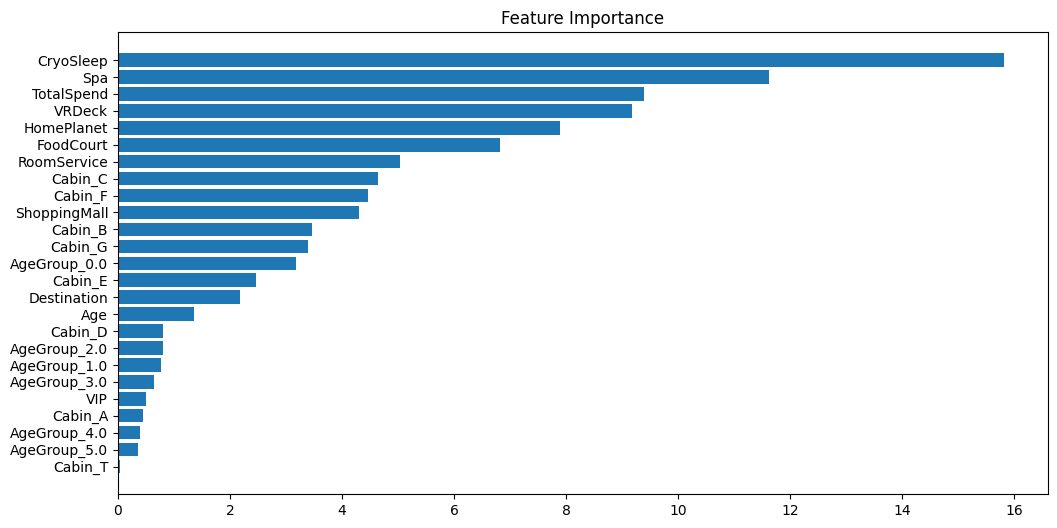

In [63]:
import matplotlib.pyplot as plt

feature_importance = best_clf2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


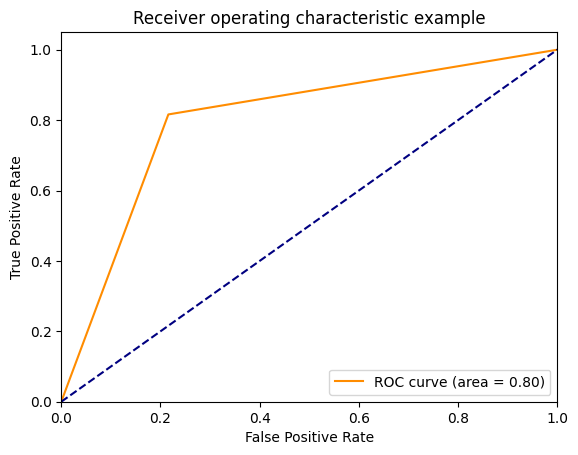

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [62]:
# test_update = pd.read_csv('./kaggle/input/spaceship-titanic/test_AgeGroup_update.csv')
test01 = test_update.drop(['PassengerId','Transported','testset','Name'],axis=1)
y_predicted=best_clf2.predict(test01)

In [65]:
submissions = pd.concat([test_update.PassengerId,pd.Series(y_predicted).map(bool)],axis=1)

In [66]:
# pred = model.predict(test_update.drop(['Transported','testset','Name','PassengerId'],axis=1))

In [67]:
submissions=submissions.rename(columns={0:'Transported'})

In [68]:
submissions.to_csv('submissionAge01.csv',index=False)